In [487]:
import pandas as pd
import numpy as np

from collections import Counter
from collections import defaultdict

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score,\
                                    RandomizedSearchCV, GridSearchCV,StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import ADASYN

from sklearn.utils import shuffle

# Data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)

## Data Preprocessing

In [488]:
df_all_c = pd.read_csv('data/data_full_upto_varThr.csv')

In [489]:
# TRAIN and TEST datasets split (and labels)
targ = 'emotion'
labels = df_all_c.pop(targ)
df_train, df_test = df_all_c.loc[:1827,:], df_all_c.loc[1828:,:]

# vars to encode
cat_vars = list(df_all_c.loc[:,'vocal_channel':'sex'].columns)

# one hot encoding of train df_train and df_test
df_train = pd.get_dummies(df_train, columns = cat_vars)
df_test = pd.get_dummies(df_test, columns = cat_vars)

# Label Encoder
le = LabelEncoder()
labels = le.fit_transform(labels)
label_encoder_name_mapping = dict(zip(le.classes_,
                                         le.transform(le.classes_)))
print("Mapping of Label Encoded Classes: ", label_encoder_name_mapping, sep="\n")

# splitting the labels in train and test
labels_train, labels_test = labels[:1828], labels[1828:]
df_train.insert(0,str(targ),labels_train)
df_test.insert(0,str(targ),labels_test)

Mapping of Label Encoded Classes: 
{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [490]:
# checking the shapes
print('train and test dfs shape: ', df_train.shape, df_test.shape)
print('train and test labels shape: ', labels_train.shape, labels_test.shape)
df_train.head()

train and test dfs shape:  (1828, 128) (624, 128)
train and test labels shape:  (1828,) (624,)


,emotion,frame_count,sum,skew,lag1_kur,zc_sum,mfcc_sum,mfcc_mean,mfcc_max,mfcc_q05,mfcc_q25,mfcc_q50,mfcc_q75,mfcc_q95,mfcc_q99,sc_sum,sc_mean,sc_std,sc_min,sc_max,sc_q01,sc_q05,sc_q25,sc_q50,sc_q75,sc_q95,sc_q99,sc_kur,stft_sum,sum_w1,kur_w1,skew_w1,lag1_kur_w1,lag1_skew_w1,zc_sum_w1,zc_q95_w1,mfcc_sum_w1,mfcc_mean_w1,mfcc_std_w1,mfcc_max_w1,mfcc_q05_w1,mfcc_q25_w1,mfcc_q50_w1,mfcc_q75_w1,mfcc_q95_w1,mfcc_q99_w1,sc_sum_w1,sc_std_w1,sc_min_w1,sc_q25_w1,sc_q75_w1,sc_q95_w1,sc_kur_w1,sc_skew_w1,stft_sum_w1,stft_kur_w1,sum_w2,kur_w2,zc_sum_w2,mfcc_min_w2,mfcc_max_w2,mfcc_q75_w2,mfcc_q95_w2,mfcc_kur_w2,sc_sum_w2,sc_mean_w2,sc_std_w2,sc_min_w2,sc_max_w2,sc_q05_w2,sc_q25_w2,sc_q50_w2,sc_kur_w2,stft_sum_w2,sum_w3,kur_w3,lag1_kur_w3,zc_sum_w3,mfcc_mean_w3,mfcc_q05_w3,mfcc_q95_w3,mfcc_q99_w3,mfcc_kur_w3,sc_sum_w3,sc_mean_w3,sc_std_w3,sc_min_w3,sc_max_w3,sc_q25_w3,sc_kur_w3,stft_sum_w3,sum_w4,kur_w4,skew_w4,lag1_kur_w4,lag1_skew_w4,zc_sum_w4,zc_q95_w4,mfcc_sum_w4,mfcc_mean_w4,mfcc_std_w4,mfcc_max_w4,mfcc_q25_w4,mfcc_q50_w4,mfcc_q95_w4,mfcc_q99_w4,sc_sum_w4,sc_mean_w4,sc_std_w4,sc_min_w4,sc_max_w4,sc_q25_w4,sc_q75_w4,sc_kur_w4,sc_skew_w4,stft_sum_w4,stft_kur_w4,stft_skew_w4,vocal_channel_song,vocal_channel_speech,emotional_intensity_normal,emotional_intensity_strong,statement_Dogs are sitting by the door,statement_Kids are talking by the door,repetition_1st,repetition_2nd,sex_F,sex_M
0,5,0.106792,0.506722,0.784505,0.260775,0.129522,0.591481,0.423199,0.717587,0.635723,0.896695,0.479183,0.261387,0.447466,0.752627,0.655516,0.954851,0.882301,0.000000,0.705391,0.385894,0.451166,0.560393,0.927656,0.951307,0.950086,0.655447,0.014217,0.528794,0.552984,0.572236,0.618010,0.699286,1.000000,0.062556,0.0,0.445355,0.133570,0.933467,0.265192,0.374045,0.679413,0.329009,0.167593,0.191928,0.483503,0.807990,0.092930,0.975799,0.965340,0.999875,0.935376,0.692039,0.780737,0.853646,0.503824,0.553195,0.691411,0.224991,0.299631,0.628919,0.652833,0.509086,0.438077,0.210342,0.405315,0.593581,0.393472,0.528451,0.404438,0.385595,0.378612,0.087534,0.466630,0.564012,0.590970,0.486622,0.224149,0.591696,0.801812,0.374269,0.833184,0.481993,0.307510,0.365604,0.769611,0.318640,0.578369,0.291006,0.533887,0.553313,0.482849,0.290004,0.738540,0.108887,0.593791,0.448805,1.0,0.597521,0.216581,0.866067,0.159312,0.653604,0.488662,0.281894,0.187912,0.738302,0.964313,0.268862,0.000000,0.901624,0.936516,0.976689,0.958815,0.102331,0.514047,0.988635,0.048224,0,1,1,0,0,1,1,0,0,1
1,5,0.116504,0.503248,0.807974,0.225783,0.148238,0.592678,0.436033,0.598435,0.506675,0.862466,0.479183,0.278588,0.470939,0.729264,0.624961,0.901829,0.812829,0.401039,0.450510,0.467991,0.450760,0.561798,0.799551,0.926962,0.943297,0.633036,0.013852,0.533221,0.600963,0.435323,0.230835,0.467376,0.617102,0.149082,1.0,0.573211,0.331577,0.819130,0.135787,0.516668,0.679413,0.522225,0.469625,0.271325,0.489737,0.764826,0.161923,0.628552,0.909069,0.989784,0.930195,0.638155,0.389996,0.867947,0.192102,0.451680,0.699709,0.198031,0.290148,0.550263,0.603532,0.441019,0.457699,0.226723,0.420190,0.495440,0.525674,0.367284,0.493723,0.394864,0.414946,0.051492,0.519341,0.611536,0.543484,0.539834,0.235869,0.614794,0.852725,0.521718,0.839149,0.449225,0.255697,0.303490,0.658337,0.305612,0.450865,0.293301,0.552003,0.507090,0.510608,0.339563,0.407132,0.128112,0.592731,0.396224,0.0,0.555675,0.159624,0.898993,0.209908,0.632088,0.413982,0.253659,0.267796,0.742450,0.956018,0.268475,0.869244,0.900040,0.872086,0.990271,0.177813,0.526318,0.483277,0.095336,0.360443,0,1,1,0,0,1,0,1,0,1
2,5,0.097081,0.507227,0.872440,0.269902,0.104711,0.602877,0.432130,0.667726,0.887036,0.896088,0.479183,0.235460,0.380469,0.801084,0.619848,0.921414,0.853955,0.000000,0.459613,0.393383,0.431250,0.472504,0.911578,0.930051,0.947636,0.642306,0.013639,0.495870,0.599825,0.100512,0.413890,0.112541,0.527296,0.149221,1.0,0.602522,0.342404,0.821121,0.156563,0.832058,0.701664,0.558589,0.466631,0.278917,0.491881,0.754973,0.123756,0.799765,0.905290,0.993358,0.930973,0.494276,0.4

In [491]:
# if we want to oversample the data
def apply_ADASYN(X, y):
    # oversampling the minority class for balanced learning
    from imblearn.over_sampling import ADASYN
    ada = ADASYN(random_state = 42)
    X, y = ada.fit_resample(X, y)
    print('resampled training set: ', X.shape, y.shape)
    print('target var. class frequencies:')
    print(Counter(y))
    return X, y

In [492]:
# converting df_train and df_test into np matrices and arrays
X, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,1:].values
y, y_test = df_train.loc[:,targ].values, df_test.loc[:,targ].values

# shuffling train and val concatenation to remove potential pattern bias
X, y  = shuffle(X, y, random_state=42)

In [493]:
# adasyn oversampling
#X, y = apply_ADASYN(X,y)

In [494]:
np.random.seed(42)  # for reproducibility

In [495]:
# all the classes of the target variable
classes = df_train[targ].unique()
classes

array([5, 1, 4, 6, 0, 3, 2, 7])

In [496]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
def rs_best_estimator(clf, param_grid, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    grid_result = grid_search.fit(X, y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))    
    return grid_search

In [497]:
# params to possibly tune
#print(gb_c.get_params().keys())
#print(hgb_c.get_params().keys())
#print(xgb_c.get_params().keys())
#print(lgbm_c.get_params().keys())

### Logistic Regression Tuning

In [498]:
from sklearn.linear_model import LogisticRegression

In [499]:
"""model_log = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01, 0.001]
param_grid1 = dict(solver=solvers,penalty=penalty,C=c_values)
rs_results_logreg = rs_best_estimator(model_log, param_grid1, X, y)"""

"model_log = LogisticRegression()\nsolvers = ['newton-cg', 'lbfgs', 'liblinear']\npenalty = ['l2']\nc_values = [100, 10, 1.0, 0.1, 0.01, 0.001]\nparam_grid1 = dict(solver=solvers,penalty=penalty,C=c_values)\nrs_results_logreg = rs_best_estimator(model_log, param_grid1, X, y)"

Best: 0.574211 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.563455 (0.026977) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.557990 (0.032526) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.566933 (0.033199) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.574211 (0.030776) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.559620 (0.030750) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.568208 (0.038618) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.567274 (0.033729) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.558712 (0.032102) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.558719 (0.030252) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.505468 (0.034454) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.504198 (0.036912) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.490346 (0.034501) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.386578 (0.028308) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.386760 (0.028369) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
0.377276 (0.030482) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.320199 (0.028972) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
0.320016 (0.028975) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
0.308338 (0.029507) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}

### SVM Tuning - Linear

In [500]:
from sklearn.svm import LinearSVC

In [501]:
"""model_lsvc = LinearSVC()
C = [50, 10, 1.0, 0.1, 0.01]
penalty = ['l1','l2']
loss=['hinge','squared_hinge']
multi_class=['ovr','crammer_singer']
param_grid2 = dict(C=C,penalty=penalty,loss=loss,multi_class=multi_class)
rs_results_lsvc = rs_best_estimator(model_lsvc, param_grid2, X, y)"""

"model_lsvc = LinearSVC()\nC = [50, 10, 1.0, 0.1, 0.01]\npenalty = ['l1','l2']\nloss=['hinge','squared_hinge']\nmulti_class=['ovr','crammer_singer']\nparam_grid2 = dict(C=C,penalty=penalty,loss=loss,multi_class=multi_class)\nrs_results_lsvc = rs_best_estimator(model_lsvc, param_grid2, X, y)"

Best: 0.568939 using {'C': 1.0, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.000000 (0.000000) with: {'C': 50, 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l1'}
0.466819 (0.047416) with: {'C': 50, 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.551239 (0.026093) with: {'C': 50, 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.551056 (0.025893) with: {'C': 50, 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l2'}
0.000000 (0.000000) with: {'C': 50, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l1'}
0.486857 (0.052086) with: {'C': 50, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.551238 (0.025998) with: {'C': 50, 'loss': 'squared_hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.551238 (0.026454) with: {'C': 50, 'loss': 'squared_hinge', 'multi_class': 'crammer_singer', 'penalty': 'l2'}
0.000000 (0.000000) with: {'C': 10, 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l1'}
0.558377 (0.033156) with: {'C': 10, 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.552515 (0.033195) with: {'C': 10, 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.552515 (0.033195) with: {'C': 10, 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l2'}
0.000000 (0.000000) with: {'C': 10, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l1'}
0.555272 (0.028884) with: {'C': 10, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.552515 (0.033195) with: {'C': 10, 'loss': 'squared_hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.552515 (0.033195) with: {'C': 10, 'loss': 'squared_hinge', 'multi_class': 'crammer_singer', 'penalty': 'l2'}
0.000000 (0.000000) with: {'C': 1.0, 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l1'}
0.531920 (0.028960) with: {'C': 1.0, 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.561446 (0.033798) with: {'C': 1.0, 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.561446 (0.033798) with: {'C': 1.0, 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l2'}
0.000000 (0.000000) with: {'C': 1.0, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l1'}
0.568939 (0.035858) with: {'C': 1.0, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.561446 (0.033798) with: {'C': 1.0, 'loss': 'squared_hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.561629 (0.033761) with: {'C': 1.0, 'loss': 'squared_hinge', 'multi_class': 'crammer_singer', 'penalty': 'l2'}
0.000000 (0.000000) with: {'C': 0.1, 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l1'}
0.485055 (0.026224) with: {'C': 0.1, 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.507293 (0.030206) with: {'C': 0.1, 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.507293 (0.030206) with: {'C': 0.1, 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l2'}
0.000000 (0.000000) with: {'C': 0.1, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l1'}
0.551427 (0.033690) with: {'C': 0.1, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.507293 (0.030206) with: {'C': 0.1, 'loss': 'squared_hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.507293 (0.030206) with: {'C': 0.1, 'loss': 'squared_hinge', 'multi_class': 'crammer_singer', 'penalty': 'l2'}
0.000000 (0.000000) with: {'C': 0.01, 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l1'}
0.499811 (0.023332) with: {'C': 0.01, 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.485413 (0.022156) with: {'C': 0.01, 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.485595 (0.022761) with: {'C': 0.01, 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l2'}
0.000000 (0.000000) with: {'C': 0.01, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l1'}
0.494343 (0.031158) with: {'C': 0.01, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.485048 (0.022338) with: {'C': 0.01, 'loss': 'squared_hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.485413 (0.022469) with: {'C': 0.01, 'loss': 'squared_hinge', 'multi_class': 'crammer_singer', 'penalty': 'l2'}

### SVM Tuning - NoLinear

In [502]:
from sklearn.svm import SVC

In [503]:
"""model_svc = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
param_grid3 = dict(C=C,kernel=kernel,gamma=gamma)
rs_results_svc = rs_best_estimator(model_svc, param_grid3, X, y)"""

"model_svc = SVC()\nkernel = ['poly', 'rbf', 'sigmoid']\nC = [50, 10, 1.0, 0.1, 0.01]\ngamma = ['scale']\nparam_grid3 = dict(C=C,kernel=kernel,gamma=gamma)\nrs_results_svc = rs_best_estimator(model_svc, param_grid3, X, y)"

Best: 0.612317 using {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.603565 (0.026598) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.581153 (0.028357) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.192184 (0.027905) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.603565 (0.026598) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.577132 (0.027379) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.229394 (0.026522) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.612317 (0.024311) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.493067 (0.025935) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.215711 (0.021866) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.576230 (0.033568) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.308895 (0.037199) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.215711 (0.021866) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.461348 (0.036630) with: {'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
0.304886 (0.036675) with: {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
0.215711 (0.021866) with: {'C': 0.01, 'gamma': 'scale', 'kernel': 'sigmoid'}

### Esemble Tuning - RadnomForest

In [504]:
from sklearn.ensemble import RandomForestClassifier

In [505]:
"""model_ranfor = RandomForestClassifier()
n_estimators = [10, 100, 1000]
criterion = ['gini', 'entropy', 'log_loss']
class_weight=['balanced', 'balanced_subsample']
min_samples_split= [2, 5, 10, 20]
min_samples_leaf= [1, 5, 10, 20]
max_features = ['sqrt', 'log2']
param_grid4 = dict(n_estimators=n_estimators,criterion=criterion,class_weight=class_weight,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,max_features=max_features)
rs_results_ranfor = rs_best_estimator(model_ranfor, param_grid4, X, y)"""

"model_ranfor = RandomForestClassifier()\nn_estimators = [10, 100, 1000]\ncriterion = ['gini', 'entropy', 'log_loss']\nclass_weight=['balanced', 'balanced_subsample']\nmin_samples_split= [2, 5, 10, 20]\nmin_samples_leaf= [1, 5, 10, 20]\nmax_features = ['sqrt', 'log2']\nparam_grid4 = dict(n_estimators=n_estimators,criterion=criterion,class_weight=class_weight,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,max_features=max_features)\nrs_results_ranfor = rs_best_estimator(model_ranfor, param_grid4, X, y)"

Best: 0.660113 using {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.474494 (0.031133) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.620544 (0.032239) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.653368 (0.034253) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.486168 (0.035170) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.620199 (0.034785) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.641342 (0.032030) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
0.485950 (0.026259) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
0.604148 (0.032226) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.624936 (0.033631) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
0.469205 (0.034488) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 10}
0.570583 (0.034399) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
0.587919 (0.028902) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1000}
0.475198 (0.039191) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.586994 (0.029748) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.605974 (0.029250) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1000}
0.471929 (0.038341) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
0.586806 (0.031700) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
0.606890 (0.034949) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}
0.471367 (0.031585) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 10}
0.590296 (0.034744) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
0.608346 (0.030566) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1000}
0.462796 (0.034787) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}
0.555258 (0.034509) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
0.580798 (0.026164) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 1000}
0.455521 (0.033936) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 10}
0.546334 (0.026235) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
0.564219 (0.029910) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}
0.467361 (0.030279) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}
0.548887 (0.033589) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
0.564577 (0.030483) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000}
0.457166 (0.035833) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 10}
0.549074 (0.034911) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
0.562021 (0.024272) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1000}
0.458972 (0.037436) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 10}
0.553634 (0.032285) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}
0.564763 (0.027509) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 1000}
0.426507 (0.037379) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 10}
0.490532 (0.029418) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 100}
0.503482 (0.030304) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 1000}
0.439464 (0.023898) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 10}
0.489799 (0.028645) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}
0.503843 (0.030792) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 1000}
0.433089 (0.034361) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 10}
0.496740 (0.029968) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}
0.502750 (0.028884) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 1000}
0.426694 (0.031416) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 10}
0.491988 (0.034321) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 100}
0.504579 (0.031463) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 1000}
0.456961 (0.033394) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.615073 (0.029604) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.646988 (0.037264) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.478864 (0.037472) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.606140 (0.032109) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.632765 (0.032893) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
0.468277 (0.032894) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
0.598474 (0.031698) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.616728 (0.031677) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
0.451674 (0.031281) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 10}
0.557469 (0.028885) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
0.582629 (0.030322) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1000}
0.470100 (0.031572) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.571121 (0.032589) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.595024 (0.027656) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1000}
0.454077 (0.032580) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
0.574040 (0.031024) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
0.597037 (0.031139) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}
0.468434 (0.033851) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 10}
0.584082 (0.032996) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
0.598311 (0.031676) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1000}
0.442905 (0.035334) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}
0.546881 (0.031248) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
0.565484 (0.030404) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 1000}
0.444562 (0.033922) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 10}
0.529377 (0.026652) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
0.546707 (0.026454) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}
0.443297 (0.031568) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}
0.533565 (0.027218) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
0.548704 (0.028147) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000}
0.453323 (0.029356) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 10}
0.527721 (0.026626) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
0.550173 (0.027028) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1000}
0.440377 (0.035139) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 10}
0.535753 (0.029781) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}
0.549803 (0.026248) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 1000}
0.420692 (0.031233) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 10}
0.485956 (0.028085) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 100}
0.494545 (0.031507) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 1000}
0.412833 (0.037791) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 10}
0.482147 (0.031024) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}
0.495272 (0.030936) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 1000}
0.424876 (0.037801) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 10}
0.484882 (0.025759) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}
0.492896 (0.030586) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 1000}
0.406639 (0.033271) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 10}
0.486154 (0.031267) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 100}
0.496002 (0.029844) with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 1000}
0.480120 (0.030234) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.632024 (0.032397) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.659927 (0.035151) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.481200 (0.032072) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.623455 (0.041519) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.647363 (0.034991) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
0.485066 (0.029959) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
0.608882 (0.034318) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.628034 (0.030900) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
0.467922 (0.034372) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 10}
0.565845 (0.029101) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
0.579348 (0.027217) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1000}
0.482484 (0.034158) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.590647 (0.029939) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.611627 (0.029599) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1000}
0.479220 (0.035081) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
0.588829 (0.029103) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
0.614172 (0.027391) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}
0.476840 (0.041652) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 10}
0.589195 (0.038078) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
0.612717 (0.027208) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1000}
0.469369 (0.027429) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}
0.559645 (0.034280) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
0.571502 (0.027724) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 1000}
0.457346 (0.031240) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 10}
0.544680 (0.033635) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
0.559102 (0.031475) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}
0.461688 (0.032044) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}
0.545972 (0.036292) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
0.555463 (0.031789) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000}
0.456437 (0.025345) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 10}
0.541415 (0.034074) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
0.560747 (0.031227) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1000}
0.450753 (0.039230) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 10}
0.544702 (0.036439) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}
0.559473 (0.029106) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 1000}
0.422131 (0.032584) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 10}
0.478119 (0.031604) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 100}
0.485419 (0.030238) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 1000}
0.425424 (0.033644) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 10}
0.479027 (0.027351) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}
0.486152 (0.029160) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 1000}
0.425772 (0.033273) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 10}
0.478853 (0.031967) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}
0.490701 (0.033320) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 1000}
0.421589 (0.029608) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 10}
0.474283 (0.029147) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 100}
0.486871 (0.029134) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 1000}
0.462259 (0.025644) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.619096 (0.037970) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.654648 (0.036392) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.478307 (0.032239) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.618549 (0.034417) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.641162 (0.036088) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
0.463359 (0.035639) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
0.594293 (0.029258) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.617085 (0.032280) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
0.442016 (0.038230) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 10}
0.546505 (0.030853) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
0.566404 (0.029831) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1000}
0.450215 (0.032914) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.579891 (0.040583) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.599948 (0.024770) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1000}
0.456044 (0.029089) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
0.577515 (0.029518) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
0.599044 (0.031038) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}
0.467326 (0.033592) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 10}
0.581904 (0.032251) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
0.599765 (0.029067) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1000}
0.441853 (0.036876) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}
0.545783 (0.034186) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
0.563845 (0.030308) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 1000}
0.443114 (0.031500) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 10}
0.532104 (0.029938) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
0.543971 (0.028323) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}
0.447329 (0.025556) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}
0.527547 (0.026323) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
0.544511 (0.028710) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000}
0.438562 (0.033765) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 10}
0.524090 (0.034793) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
0.544696 (0.026985) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1000}
0.440537 (0.042992) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 10}
0.532650 (0.023751) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}
0.543423 (0.028101) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 1000}
0.405545 (0.028865) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 10}
0.475394 (0.029147) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 100}
0.483043 (0.032796) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 1000}
0.410280 (0.035190) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 10}
0.478486 (0.023198) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}
0.486147 (0.026140) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 1000}
0.409551 (0.033802) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 10}
0.479959 (0.033862) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}
0.485597 (0.029974) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 1000}
0.405917 (0.032665) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 10}
0.474647 (0.031432) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 100}
0.486152 (0.031139) with: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 1000}
0.483599 (0.039042) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.629852 (0.030726) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.656285 (0.037318) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.489251 (0.036764) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.632388 (0.030090) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.648631 (0.035179) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
0.496537 (0.038625) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
0.609970 (0.029680) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.626932 (0.028650) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
0.470662 (0.034107) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 10}
0.559096 (0.029821) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
0.579715 (0.029564) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1000}
0.476122 (0.041258) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.593553 (0.028420) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.614893 (0.031508) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1000}
0.475373 (0.034313) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
0.590316 (0.037443) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
0.612531 (0.026011) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}
0.487066 (0.031518) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 10}
0.595206 (0.033215) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
0.611799 (0.029617) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1000}
0.471731 (0.030960) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}
0.556002 (0.034431) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
0.572234 (0.029415) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 1000}
0.456799 (0.029496) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 10}
0.540117 (0.029878) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
0.559826 (0.029794) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}
0.464636 (0.036625) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}
0.546702 (0.037641) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
0.559102 (0.029136) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000}
0.453682 (0.026838) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 10}
0.544344 (0.036351) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
0.557108 (0.029563) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1000}
0.457537 (0.034343) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 10}
0.546150 (0.032648) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}
0.559829 (0.026918) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 1000}
0.425775 (0.027575) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 10}
0.474844 (0.030575) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 100}
0.489064 (0.029358) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 1000}
0.416127 (0.032367) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 10}
0.476481 (0.037064) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}
0.491436 (0.031145) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 1000}
0.421217 (0.027726) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 10}
0.476647 (0.034354) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}
0.487234 (0.030617) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 1000}
0.420674 (0.036566) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 10}
0.475567 (0.030128) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 100}
0.491432 (0.032649) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 1000}
0.474313 (0.033083) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.616723 (0.035553) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.652085 (0.037305) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.470277 (0.033736) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.610513 (0.035371) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.642622 (0.037417) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
0.466472 (0.033366) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
0.599592 (0.031495) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.616719 (0.032303) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
0.446028 (0.031101) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 10}
0.543234 (0.023902) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
0.569310 (0.026340) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1000}
0.465914 (0.029204) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.580253 (0.032299) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.600129 (0.032320) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1000}
0.467745 (0.041165) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
0.578056 (0.029446) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
0.603950 (0.027686) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}
0.474121 (0.035695) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 10}
0.579160 (0.036518) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
0.601405 (0.029170) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1000}
0.445837 (0.028407) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}
0.534658 (0.027964) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
0.560014 (0.028741) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 1000}
0.436908 (0.026131) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 10}
0.531928 (0.031262) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
0.542151 (0.026487) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}
0.441493 (0.038465) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}
0.520984 (0.026329) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
0.543241 (0.028300) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000}
0.441282 (0.040136) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 10}
0.523545 (0.034395) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
0.545419 (0.031159) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1000}
0.431093 (0.038230) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 10}
0.532831 (0.028370) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}
0.547439 (0.027725) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 1000}
0.406113 (0.033086) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 10}
0.471374 (0.028920) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 100}
0.489252 (0.032342) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 1000}
0.415728 (0.037263) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 10}
0.478853 (0.029399) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}
0.485779 (0.030476) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 1000}
0.413567 (0.035061) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 10}
0.480304 (0.031868) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}
0.482852 (0.033439) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 1000}
0.404999 (0.027213) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 10}
0.472835 (0.033040) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 100}
0.486873 (0.031381) with: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 1000}
0.453875 (0.024368) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.622358 (0.036081) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.649190 (0.036989) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.479965 (0.030008) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.622728 (0.035629) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.640609 (0.035154) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
0.484334 (0.039834) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
0.604679 (0.038906) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.624022 (0.033765) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
0.473746 (0.031179) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 10}
0.573325 (0.028569) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
0.596128 (0.025436) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1000}
0.481607 (0.035275) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.586103 (0.031739) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.605613 (0.030231) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1000}
0.479757 (0.037334) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
0.585723 (0.029325) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
0.608520 (0.029062) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}
0.486502 (0.041957) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 10}
0.585010 (0.036384) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
0.606510 (0.030309) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1000}
0.466811 (0.032768) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}
0.562208 (0.031814) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
0.579902 (0.028636) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 1000}
0.459533 (0.033797) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 10}
0.543058 (0.034431) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
0.560389 (0.032065) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}
0.465351 (0.036212) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}
0.545594 (0.032305) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
0.563848 (0.024919) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000}
0.460441 (0.036879) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 10}
0.545960 (0.029527) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
0.562573 (0.027805) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1000}
0.461163 (0.032072) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 10}
0.543968 (0.032335) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}
0.559467 (0.030270) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 1000}
0.424318 (0.035103) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 10}
0.494899 (0.035395) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 100}
0.502392 (0.030828) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 1000}
0.431988 (0.037106) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 10}
0.497283 (0.033832) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}
0.502209 (0.030883) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 1000}
0.426717 (0.029222) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 10}
0.499101 (0.034980) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}
0.503480 (0.031408) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 1000}
0.433808 (0.036864) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 10}
0.489805 (0.029869) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 100}
0.505855 (0.031442) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 1000}
0.460994 (0.028143) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.609239 (0.036061) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.647901 (0.037382) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.456412 (0.030207) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.610884 (0.036859) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.640614 (0.036480) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
0.458615 (0.030529) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
0.587724 (0.033434) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.617098 (0.035294) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
0.446017 (0.039009) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 10}
0.560918 (0.032887) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
0.580260 (0.031854) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1000}
0.458252 (0.038278) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.582264 (0.037264) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.595575 (0.029386) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1000}
0.463713 (0.034397) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
0.575691 (0.036471) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
0.595942 (0.030502) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}
0.458631 (0.033972) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 10}
0.574052 (0.034218) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
0.595218 (0.035790) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1000}
0.442017 (0.030696) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}
0.547060 (0.023045) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
0.569491 (0.027500) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 1000}
0.445677 (0.035860) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 10}
0.534303 (0.034540) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
0.551629 (0.031989) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}
0.439117 (0.039289) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}
0.527738 (0.031886) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
0.550904 (0.029150) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000}
0.442179 (0.030266) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 10}
0.531742 (0.030309) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
0.550356 (0.028537) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1000}
0.436911 (0.034138) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 10}
0.535947 (0.029331) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}
0.551264 (0.029312) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 1000}
0.412286 (0.036594) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 10}
0.488163 (0.031310) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 100}
0.495086 (0.027309) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 1000}
0.413378 (0.033686) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 10}
0.484706 (0.035243) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}
0.492362 (0.032564) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 1000}
0.411934 (0.031260) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 10}
0.480326 (0.034153) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}
0.493085 (0.029016) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 1000}
0.415742 (0.031337) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 10}
0.484508 (0.027218) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 100}
0.494734 (0.031965) with: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 1000}
0.476308 (0.032324) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.634395 (0.039420) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.659575 (0.036770) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.495109 (0.041602) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.631858 (0.039658) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.655012 (0.031731) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
0.491980 (0.036552) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
0.609968 (0.027646) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.628213 (0.030077) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
0.465544 (0.031782) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 10}
0.560382 (0.037379) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
0.580070 (0.028963) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1000}
0.487990 (0.030424) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.588081 (0.026103) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.613991 (0.027541) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1000}
0.486689 (0.031571) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
0.593743 (0.031569) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
0.613079 (0.029436) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}
0.473376 (0.035824) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 10}
0.600320 (0.035698) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
0.613623 (0.025146) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1000}
0.467575 (0.034715) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}
0.556907 (0.034021) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
0.569686 (0.027891) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 1000}
0.447515 (0.030924) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 10}
0.549792 (0.032118) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
0.553450 (0.026991) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}
0.456053 (0.037008) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}
0.544682 (0.036123) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
0.560741 (0.029303) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000}
0.466815 (0.029678) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 10}
0.542149 (0.032893) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
0.554360 (0.029504) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1000}
0.458817 (0.039566) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 10}
0.539957 (0.031082) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}
0.560376 (0.029146) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 1000}
0.427792 (0.036081) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 10}
0.479958 (0.030734) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 100}
0.486872 (0.031506) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 1000}
0.426328 (0.031871) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 10}
0.486150 (0.030347) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}
0.486872 (0.030687) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 1000}
0.421774 (0.040182) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 10}
0.479947 (0.027178) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}
0.488525 (0.032379) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 1000}
0.427426 (0.030134) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 10}
0.481055 (0.032187) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 100}
0.487236 (0.030615) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 1000}
0.458263 (0.037229) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.623279 (0.032385) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.655374 (0.036875) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.472122 (0.034555) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.615990 (0.040023) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.644809 (0.035378) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
0.462265 (0.037487) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
0.589369 (0.032636) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.611613 (0.029540) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
0.457872 (0.038275) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 10}
0.548335 (0.035893) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
0.566584 (0.029697) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1000}
0.461712 (0.028847) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.576242 (0.034568) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.596113 (0.026925) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1000}
0.456226 (0.030623) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
0.579876 (0.028940) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
0.601598 (0.028809) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}
0.454976 (0.030836) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 10}
0.576618 (0.033610) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
0.601397 (0.026880) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1000}
0.446057 (0.041435) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}
0.539388 (0.026166) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
0.564576 (0.030564) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 1000}
0.432711 (0.025897) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 10}
0.529364 (0.026330) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
0.545056 (0.030897) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}
0.441840 (0.036666) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}
0.526639 (0.031422) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
0.541604 (0.031716) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000}
0.442572 (0.033662) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 10}
0.535207 (0.023578) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
0.543420 (0.027904) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1000}
0.447833 (0.037337) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 10}
0.533386 (0.037205) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}
0.543235 (0.028445) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 1000}
0.418672 (0.023090) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 10}
0.476304 (0.030021) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 100}
0.484870 (0.031706) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 1000}
0.411921 (0.026515) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 10}
0.471737 (0.032633) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}
0.485600 (0.030621) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 1000}
0.407368 (0.028044) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 10}
0.473208 (0.029900) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}
0.485602 (0.027884) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 1000}
0.405372 (0.025708) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 10}
0.475398 (0.028189) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 100}
0.484688 (0.029980) with: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 1000}
0.474288 (0.038340) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.623283 (0.030533) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.660113 (0.035529) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.472276 (0.037928) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.626016 (0.034095) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.650451 (0.031554) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
0.487795 (0.024741) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
0.614528 (0.028584) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.624205 (0.033010) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
0.471742 (0.040140) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 10}
0.563100 (0.033169) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
0.577894 (0.032554) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1000}
0.478315 (0.030103) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.596305 (0.030557) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.611986 (0.027847) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1000}
0.481589 (0.028473) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
0.593024 (0.030166) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
0.613081 (0.028040) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}
0.475937 (0.039690) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 10}
0.595401 (0.032345) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
0.610160 (0.030161) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1000}
0.469193 (0.033762) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}
0.559291 (0.034533) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
0.572602 (0.030958) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 1000}
0.459361 (0.040794) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 10}
0.537404 (0.032114) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
0.556916 (0.027657) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}
0.468276 (0.034682) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}
0.544881 (0.033449) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
0.556368 (0.030738) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000}
0.461699 (0.034735) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 10}
0.541404 (0.030379) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
0.555092 (0.029579) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1000}
0.462629 (0.038002) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 10}
0.541054 (0.035312) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}
0.558196 (0.029983) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 1000}
0.422324 (0.030531) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 10}
0.478670 (0.030684) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 100}
0.490528 (0.029680) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 1000}
0.431444 (0.028270) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 10}
0.477756 (0.032612) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}
0.486322 (0.032535) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 1000}
0.433476 (0.033993) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 10}
0.483245 (0.036161) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}
0.489069 (0.028200) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 1000}
0.425399 (0.034962) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 10}
0.485966 (0.034107) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 100}
0.487602 (0.032121) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 1000}
0.462790 (0.033710) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.626747 (0.034755) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.654093 (0.033908) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
0.468089 (0.034105) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.625654 (0.038311) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.643162 (0.033394) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
0.473032 (0.028505) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
0.591732 (0.029755) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.616732 (0.031038) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
0.446568 (0.043051) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 10}
0.548875 (0.030062) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
0.564937 (0.033994) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 1000}
0.447297 (0.027652) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.579160 (0.027558) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.600862 (0.029065) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1000}
0.455710 (0.037201) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
0.579150 (0.038564) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
0.600486 (0.026179) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}
0.461856 (0.039229) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 10}
0.576608 (0.031622) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
0.597025 (0.033555) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1000}
0.452599 (0.028590) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}
0.549805 (0.031780) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}
0.561837 (0.029023) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 1000}
0.435822 (0.037289) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 10}
0.526648 (0.035829) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
0.546336 (0.030497) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}
0.444743 (0.035038) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}
0.532472 (0.028169) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
0.544697 (0.028236) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000}
0.441298 (0.038179) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 10}
0.529192 (0.032458) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
0.546526 (0.031223) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1000}
0.433649 (0.025805) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 10}
0.528832 (0.030069) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}
0.543237 (0.026464) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 1000}
0.411933 (0.031127) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 10}
0.476299 (0.026132) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 100}
0.481232 (0.030433) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 1000}
0.413733 (0.030985) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 10}
0.483047 (0.025034) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}
0.482490 (0.030469) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 1000}
0.408302 (0.034216) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 10}
0.474110 (0.029614) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}
0.484139 (0.028420) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 1000}
0.407944 (0.039422) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 10}
0.477748 (0.030649) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 100}
0.485601 (0.031145) with: {'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 1000}

###Testing 

In [506]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall, plot_precision_recall_curve
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV

In [507]:
"""rndfor_c = RandomForestClassifier(class_weight= 'balanced_subsample', criterion= 'log_loss', max_features= 'sqrt',min_samples_leaf= 1, min_samples_split= 2, n_estimators= 1000)
rndfor_c = rndfor_c.fit(X,y)
y_hat_rndfor_c = rndfor_c.predict(X_test).ravel()
acc_score_rndfor_c = accuracy_score(y_test, y_hat_rndfor_c)
f1_rndfor_c = f1_score(y_test, y_hat_rndfor_c, average=None)

print(f'Accuracy: {acc_score_rndfor_c}')
print()
print(f'F1-score: {f1_rndfor_c}')
print()
print(classification_report(y_test, y_hat_rndfor_c, target_names=label_encoder_name_mapping))

y_test_pred_proba = rndfor_c.predict_proba(X_test)
y_proba = y_test_pred_proba/y_test_pred_proba.sum(axis=1,keepdims=1)

y_test_dec = le.inverse_transform(y_test)

plot_roc(y_test_dec, rndfor_c.predict_proba(X_test), figsize=(10,8))
plt.title(f'ROC for RandomForest\n AUC: {roc_auc_score(y_test_dec, y_proba, multi_class="ovr", average="micro")}')
plt.show()"""

'rndfor_c = RandomForestClassifier(class_weight= \'balanced_subsample\', criterion= \'log_loss\', max_features= \'sqrt\',min_samples_leaf= 1, min_samples_split= 2, n_estimators= 1000)\nrndfor_c = rndfor_c.fit(X,y)\ny_hat_rndfor_c = rndfor_c.predict(X_test).ravel()\nacc_score_rndfor_c = accuracy_score(y_test, y_hat_rndfor_c)\nf1_rndfor_c = f1_score(y_test, y_hat_rndfor_c, average=None)\n\nprint(f\'Accuracy: {acc_score_rndfor_c}\')\nprint()\nprint(f\'F1-score: {f1_rndfor_c}\')\nprint()\nprint(classification_report(y_test, y_hat_rndfor_c, target_names=label_encoder_name_mapping))\n\ny_test_pred_proba = rndfor_c.predict_proba(X_test)\ny_proba = y_test_pred_proba/y_test_pred_proba.sum(axis=1,keepdims=1)\n\ny_test_dec = le.inverse_transform(y_test)\n\nplot_roc(y_test_dec, rndfor_c.predict_proba(X_test), figsize=(10,8))\nplt.title(f\'ROC for RandomForest\n AUC: {roc_auc_score(y_test_dec, y_proba, multi_class="ovr", average="micro")}\')\nplt.show()'

Accuracy: 0.47596153846153844

F1-score: [0.58515284 0.53807107 0.55652174 0.41891892 0.4040404  0.48598131
 0.34355828 0.43956044]

              precision    recall  f1-score   support

           0       0.50      0.70      0.59        96
           1       0.52      0.55      0.54        96
           2       0.48      0.67      0.56        48
           3       0.60      0.32      0.42        96
           4       0.39      0.42      0.40        96
           5       0.44      0.54      0.49        48
           6       0.42      0.29      0.34        96
           7       0.47      0.42      0.44        48

    accuracy                           0.48       624
   macro avg       0.48      0.49      0.47       624
weighted avg       0.48      0.48      0.47       624



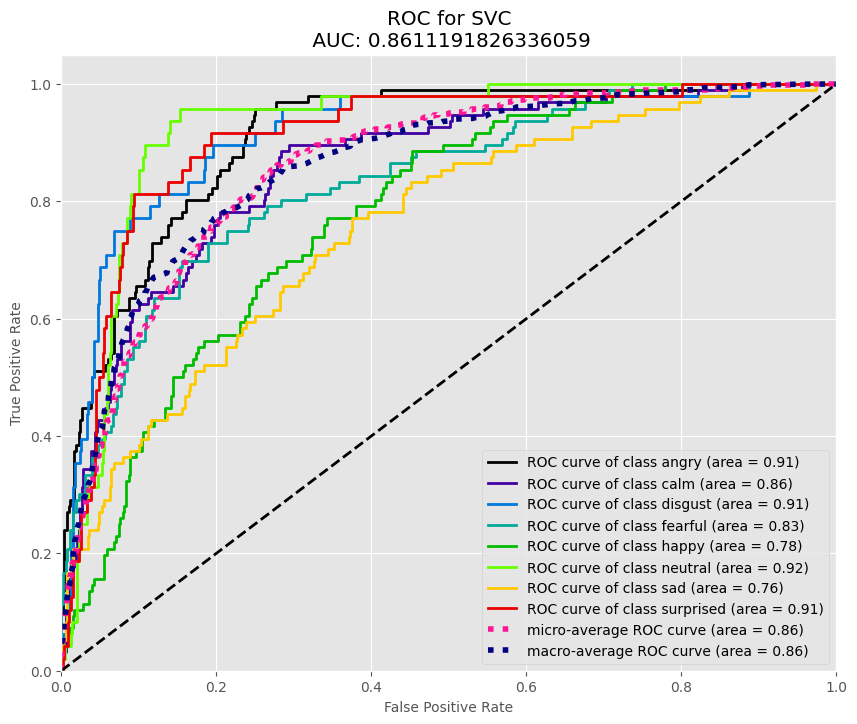

In [508]:
svc_c = SVC(C=1.0, gamma= 'scale', kernel= 'poly', probability=True,decision_function_shape='ovo')
svc_c  = svc_c.fit(X,y)
y_hat_svc_c  = svc_c.predict(X_test).ravel()
acc_score_svc_c  = accuracy_score(y_test, y_hat_svc_c )
f1_svc_c  = f1_score(y_test, y_hat_svc_c , average=None)

print(f'Accuracy: {acc_score_svc_c}')
print()
print(f'F1-score: {f1_svc_c}')
print()
print(classification_report(y_test, y_hat_svc_c))

y_test_pred_proba = svc_c.predict_proba(X_test)
y_proba = y_test_pred_proba/y_test_pred_proba.sum(axis=1,keepdims=1)

y_test_dec = le.inverse_transform(y_test)

plot_roc(y_test_dec, svc_c.predict_proba(X_test), figsize=(10,8))
plt.title(f'ROC for SVC\n AUC: {roc_auc_score(y_test_dec, y_proba, multi_class="ovr", average="micro")}')
plt.show()

### Let's figure out the differences between POLY and RBF Kernel ( Best kernel found during hyperparameter tuning)

In [509]:
X_all=pd.concat([df_train.iloc[:,1:], df_test.iloc[:,1:]], axis=0)
y_all=pd.concat([df_train.loc[:,targ], df_test.loc[:,targ]], axis=0)



In [510]:
X_all=X_all.values
y_all=y_all.values

In [511]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [512]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import numpy as np

In [513]:
from sklearn.decomposition import PCA

In [514]:
pca = PCA(n_components=2)
X=pca.fit(X).transform(X)

In [515]:
X

array([[-0.27281989, -1.02753478],
       [ 0.42870675, -1.72442772],
       [ 1.59608027,  0.04910869],
       ...,
       [ 0.46127459, -1.28887571],
       [-0.19176855, -1.627699  ],
       [-1.73474725,  0.21427251]])

In [516]:
sig = SVC(C = 10, gamma= 'scale', kernel= 'sigmoid',probability=True,decision_function_shape='ovo').fit(X, y)
rbf = SVC(C= 50, gamma= 'scale', kernel= 'rbf',probability=True,decision_function_shape='ovo').fit(X, y)
poly = SVC(C=1.0, gamma= 'scale', kernel= 'poly', probability=True,decision_function_shape='ovo').fit(X, y)

In [517]:
#stepsize in the mesh, it alters the accuracy of the plotprint
#to better understand it, just play with the value, change it and print it
h = .01
#create the mesh
x_min, x_max = X_all[:, 0].min() - 1, X_all[:, 0].max() + 1
y_min, y_max = X_all[:, 1].min() - 1, X_all[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
# create the title that will be shown on the plot
titles = ['Sigmoid kernel','RBF kernel','Polynomial kernel']
xx

array([[-1.  , -0.99, -0.98, ...,  1.97,  1.98,  1.99],
       [-1.  , -0.99, -0.98, ...,  1.97,  1.98,  1.99],
       [-1.  , -0.99, -0.98, ...,  1.97,  1.98,  1.99],
       ...,
       [-1.  , -0.99, -0.98, ...,  1.97,  1.98,  1.99],
       [-1.  , -0.99, -0.98, ...,  1.97,  1.98,  1.99],
       [-1.  , -0.99, -0.98, ...,  1.97,  1.98,  1.99]])

In [ ]:
yy

array([[-1.  , -1.  , -1.  , ..., -1.  , -1.  , -1.  ],
       [-0.99, -0.99, -0.99, ..., -0.99, -0.99, -0.99],
       [-0.98, -0.98, -0.98, ..., -0.98, -0.98, -0.98],
       ...,
       [ 1.97,  1.97,  1.97, ...,  1.97,  1.97,  1.97],
       [ 1.98,  1.98,  1.98, ...,  1.98,  1.98,  1.98],
       [ 1.99,  1.99,  1.99, ...,  1.99,  1.99,  1.99]])

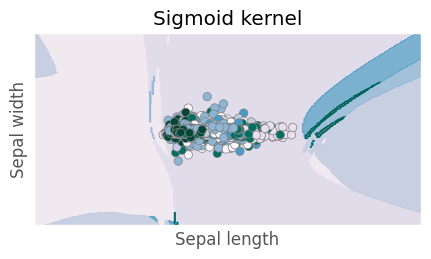

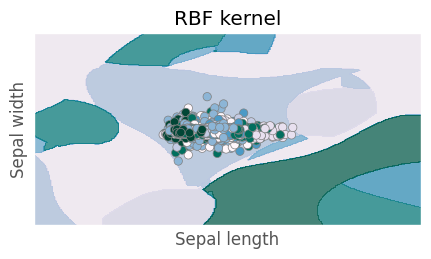

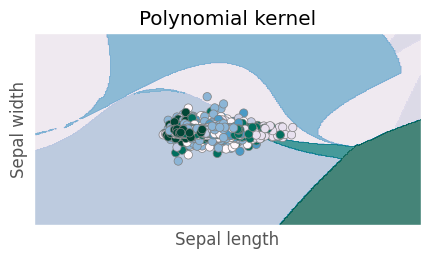

In [518]:
for i, clf in enumerate((sig, rbf, poly)):
    #defines how many plots: 2 rows, 2columns=> leading to 4 plots
    plt.subplot(2, 2, i + 1) #i+1 is the index
    #space between plots
    plt.subplots_adjust(wspace=0.4, hspace=0.4) 
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.PuBuGn, alpha=0.7)
    # Plot also the training points
    plt.scatter(X_all[:, 0], X_all[:, 1], c=y_all, cmap=plt.cm.PuBuGn,     edgecolors='grey')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
    plt.show()

c:\Users\marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.46474358974358976

F1-score: [0.62978723 0.53125    0.51666667 0.39735099 0.39269406 0.43678161
 0.24657534 0.48979592]

              precision    recall  f1-score   support

       angry       0.53      0.77      0.63        96
        calm       0.53      0.53      0.53        96
     disgust       0.43      0.65      0.52        48
     fearful       0.55      0.31      0.40        96
       happy       0.35      0.45      0.39        96
     neutral       0.49      0.40      0.44        48
         sad       0.36      0.19      0.25        96
   surprised       0.48      0.50      0.49        48

    accuracy                           0.46       624
   macro avg       0.46      0.47      0.46       624
weighted avg       0.46      0.46      0.45       624



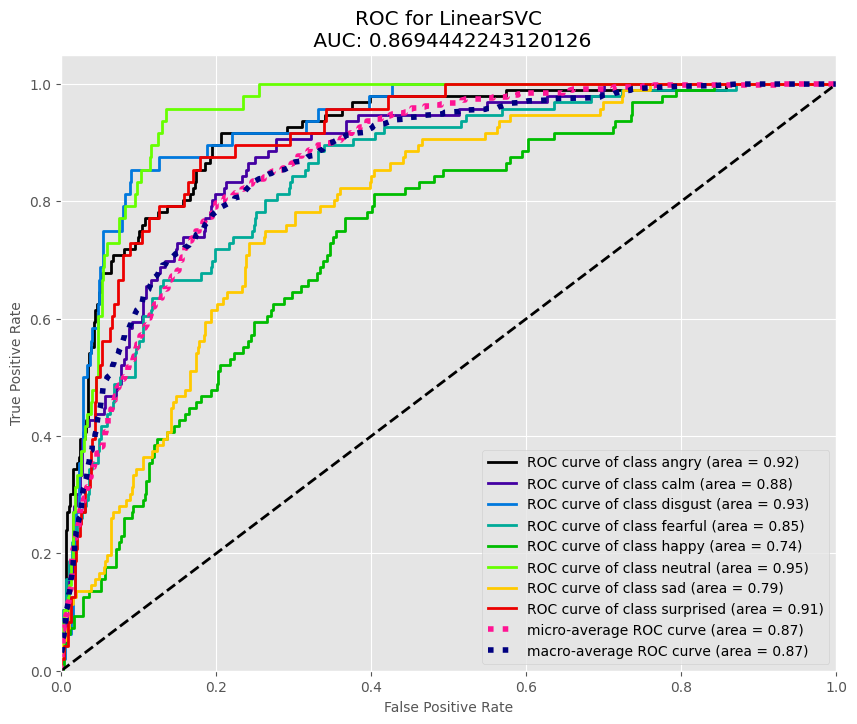

In [203]:
clf=LinearSVC(C= 1.0, loss= 'squared_hinge', multi_class= 'ovr', penalty= 'l2')
linsvc_c = CalibratedClassifierCV(clf)
linsvc_c= linsvc_c.fit(X,y)
y_hat_linsvc_c = linsvc_c.predict(X_test).ravel()
acc_score_linsvc_c  = accuracy_score(y_test, y_hat_linsvc_c )
f1_linsvc_c  = f1_score(y_test, y_hat_linsvc_c , average=None)

print(f'Accuracy: {acc_score_linsvc_c}')
print()
print(f'F1-score: {f1_linsvc_c}')
print()
print(classification_report(y_test, y_hat_linsvc_c, target_names=label_encoder_name_mapping))

y_test_pred_proba = linsvc_c.predict_proba(X_test)
y_proba = y_test_pred_proba/y_test_pred_proba.sum(axis=1,keepdims=1)

y_test_dec = le.inverse_transform(y_test)

plot_roc(y_test_dec, linsvc_c.predict_proba(X_test), figsize=(10,8))
plt.title(f'ROC for LinearSVC\n AUC: {roc_auc_score(y_test_dec, y_proba, multi_class="ovr", average="micro")}')
plt.show()

Accuracy: 0.4791666666666667

F1-score: [0.64573991 0.55026455 0.48818898 0.41610738 0.36866359 0.54347826
 0.29139073 0.52      ]

              precision    recall  f1-score   support

       angry       0.57      0.75      0.65        96
        calm       0.56      0.54      0.55        96
     disgust       0.39      0.65      0.49        48
     fearful       0.58      0.32      0.42        96
       happy       0.33      0.42      0.37        96
     neutral       0.57      0.52      0.54        48
         sad       0.40      0.23      0.29        96
   surprised       0.50      0.54      0.52        48

    accuracy                           0.48       624
   macro avg       0.49      0.50      0.48       624
weighted avg       0.49      0.48      0.47       624



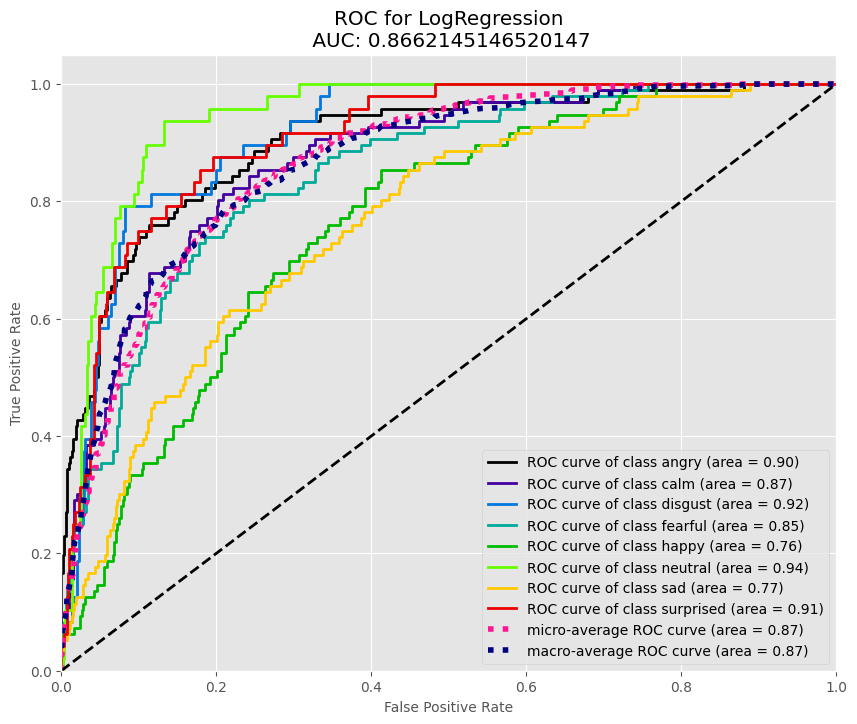

In [204]:
log_c = LogisticRegression(C= 10, penalty= 'l2', solver= 'newton-cg')
log_c = log_c.fit(X,y)
y_hat_log_c = log_c.predict(X_test).ravel()
acc_score_log_c  = accuracy_score(y_test, y_hat_log_c )
f1_log_c = f1_score(y_test, y_hat_log_c , average=None)

print(f'Accuracy: {acc_score_log_c}')
print()
print(f'F1-score: {f1_log_c}')
print()
print(classification_report(y_test, y_hat_log_c, target_names=label_encoder_name_mapping))

y_test_pred_proba = log_c.predict_proba(X_test)
y_proba = y_test_pred_proba/y_test_pred_proba.sum(axis=1,keepdims=1)

y_test_dec = le.inverse_transform(y_test)

plot_roc(y_test_dec, log_c.predict_proba(X_test), figsize=(10,8))
plt.title(f'ROC for LogRegression\n AUC: {roc_auc_score(y_test_dec, y_proba, multi_class="ovr", average="micro")}')
plt.show()

Linear SVC 'C': 1.0, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l2'
Logistic 'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'